In [17]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

In [24]:
# Load the data (cat / not cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], its a cat picture.


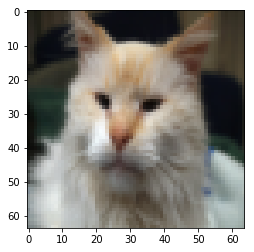

In [29]:
# Example of a picture

index = 27
plt.imshow(train_set_x_orig[index])
print("y = " + str(train_set_y[:, index]) + ", its a " + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + " picture.")

In [30]:
"""
find values for
m_train (number of tarining examples)
m_test (number of trest examples)
num_px (= height = width of training image)
"""

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [33]:
# Need to flatten image to be one column numpy arrays

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [34]:
# Standardize the datasets
"""
Once common preprocessing step in machine learning is to center and standardize your dataset, meaning that you 
substract the mean of the whole numpy array from each example, and then divide each example by the standard
deviation of the whole numpy array.  But for picture datasets, it is simpler and more convenient and works
almost as well to just divide every row of the dataset by 255(the max value of a pixel channel)
"""

train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

In [35]:
"""
What I just did was:
 - Figure out the deminsions and shapes of the problem(m_train, m_test, num_px, ...)
 - Reshape the datasets such that each example is now a vector of size (num_px*num_px*3,1)
 - Standardize the data
 
Next Steps:
 - Initialize the parameters of the model
 - Learn the parameters for the model by minimizing the cost
 - Use the learned parameters to make predictions (on the test set)
 - Analyse the results and conclude
  
Main Steps for Build a Nueral Network Are:
 - Define the model structure (such as number of input features)
 - initialize the model's parameters
 - Loop:
    - Calculate current loss (forward propagation)
    - Calcualte current gradient (backward propagation)
    - Update parameters (gradient descent)
    
 - Note: You often do the first 3 separately and integrate them into one function we call 'model()'
 """

'\nWhat I just did was:\n - Figure out the deminsions and shapes of the problem(m_train, m_test, num_px, ...)\n - Reshape the datasets such that each example is now a vector of size (num_px*num_px*3,1)\n - Standardize the data\n '

In [36]:
def sigmoid(z):
    """
    Compute the sigmoid of z
    
    Arguments:
    z -- A scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    """
    
    s = 1 / (1 + np.exp(-z))
    
    return s

In [37]:
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


In [41]:
# Graded function

def initialize_with_zeros(dim):
    """
    this function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0
    
    Argument: 
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros([dim, 1])
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [42]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


In [43]:
# Forward and Backward propagation
# this function computes the cost function and its gradient

def propagate(w, b, X, Y):
    """
    Implement the cost function and tis gradient for the propagation
    
    Arguments:
    w -- weights, a numpy array of size (num_px*num_px*3,1)
    b -- bias, a scalar
    X -- data of size (num_px*num_px*3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of expamples)
    
    Return:
        cost -- negative log-likelihood cost for logistic regression
        dw -- gradient of the loss with respect to w, thus same shape as w
        db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]
    
    # Forward Propagation (from x to cost)
    
    A = sigmoid(np.dot(w.T, X) + b)
    cost = (-1. / m) * np.sum((Y*np.log(A) + (1 - Y)*np.log(1-A)), axis=1)
    
    # Backward Propagation (to find gradient)
    
    dw = (1./m)*np.dot(X,((A-Y).T))
    db = (1./m)*np.sum(A-Y, axis=1)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [44]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = [0.00145558]
cost = 5.801545319394553


In [45]:
# Optimization - Update parameters with Gradient Descent

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        grads, cost = propagate(w=w, b=b, X=X, Y=Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        w = w - learning_rate*dw
        b = b -  learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [50]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = [1.92535983]
dw = [[0.67752042]
 [1.41625495]]
db = [0.2191945]


In [51]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0, i] >= 0.5:
            Y_prediction[0, i] = 1
            
        else:
            Y_prediction[0, i] = 0

    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [54]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

[0.52241976 0.50960677 0.34597965]
predictions = [[1. 1. 0.]]


In [55]:
#Graded function: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])
    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [56]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
[0.94366988 0.86095311 0.88896715 0.93630641 0.74075403 0.52849619
 0.03094677 0.85707681 0.88457925 0.67279696 0.26601085 0.4823794
 0.74741157 0.78575729 0.00978911 0.9203284  0.02453695 0.84884703
 0.2050248  0.03703224 0.92931392 0.11930532 0.01411064 0.7832698
 0.58188015 0.66897565 0.7

y = 1, you predicted that it is a "cat" picture.


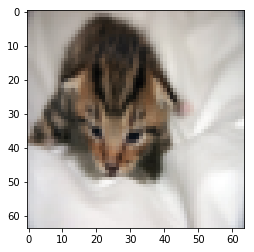

In [57]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")


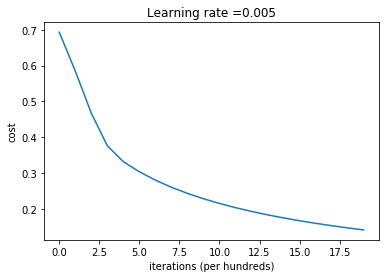

In [58]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
[0.97125943 0.9155338  0.92079132 0.96358044 0.78924234 0.60411297
 0.01179527 0.89814048 0.91522859 0.70264065 0.19380387 0.49537355
 0.7927164  0.85423431 0.00298587 0.96199699 0.01234735 0.9107653
 0.13661137 0.01424336 0.96894735 0.1033746  0.00579297 0.86081326
 0.53811196 0.64950178 0.83272843 0.00426307 0.0131452  0.99947804
 0.11468372 0.82182442 0.69611733 0.4991522  0.67231401 0.01728165
 0.04136099 0.80069693 0.26832359 0.03958566 0.74731239 0.32116434
 0.71871197 0.01205725 0.96879962 0.62310364 0.17737126 0.98960523
 0.74697265 0.07284605]
[1.47839654e-01 5.78008187e-02 9.42385025e-01 4.14849240e-05
 2.27209941e-02 7.29254668e-02 2.23704495e-02 9.49717864e-01
 5.41724296e-02 2.92729895e-02 6.82412299e-02 8.33370210e-01
 1.71420615e-01 9.66879883e-01 8.11537151e-01 2.44343484e-02
 7.87634097e-03 2.64027272e-02 5.60720049e-02 9.53130353e-01
 5.30865324e-03 3.11020746e-02 1.43606493e-01 1.92650473e-02
 9.30132798e-01 8.95291211e-01 2.72790550e-02 9.0148

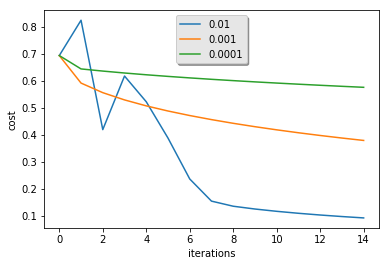

"\nInterpretation:\n\nDifferent learning rates give different costs and thus different predictions results.\nIf the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost).\nA lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.\nIn deep learning, we usually recommend that you:\nChoose the learning rate that better minimizes the cost function.\nIf your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.)\n"

In [60]:
#Choice of Learning Rates

learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

"""
Interpretation:

Different learning rates give different costs and thus different predictions results.
If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge
(though in this example, using 0.01 still eventually ends up at a good value for the cost).
A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. 
It happens when the training accuracy is a lot higher than the test accuracy.
In deep learning, we usually recommend that you:
Choose the learning rate that better minimizes the cost function.
If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.)
"""

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  # This is added back by InteractiveShellApp.init_path()


[5.881844e-275]
y = 0.0, your algorithm predicts a "non-cat" picture.


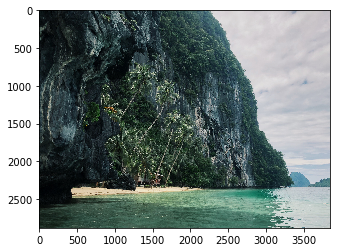

In [64]:
# Test Your Own Image

# my_image = "IMG_0203-pax.JPG"

my_image = "paradise.JPG"

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(plt.imread(fname))
image = image/255
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + 
      classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

